In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

# List all input files
for dirname, _, filenames in os.walk('./think-cell-datathon/images/'):
    for filename in filenames:
        if not "chart" in filename:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./think-cell-datathon/images/.DS_Store
./think-cell-datathon/images/images/.DS_Store


In [4]:
def load_pie_data(filepath):
    # Load data from CSV file into a DataFrame
    data = pd.read_csv(filepath)

    # Convert string representation of lists back to actual lists
    list_data_features = ["boxes", "start_angles", "end_angles", "angles", "percentages"]
    for column in list_data_features:
        data[column] = data[column].apply(ast.literal_eval)

    return data

train_df = load_pie_data("./think-cell-datathon/train.csv")


In [5]:
print("Number of training images:", len(train_df))
train_df.head(n=3)

Number of training images: 10000


,id,filename,boxes,start_angles,end_angles,angles,percentages
0,0,chart_0.png,"[[268, 144, 268, 148, 163, 144], [268, 148, 16...","[90.0, 92.18164140355147, 178.9087837747374]","[92.18164140355147, 178.9087837747374, 450.0]","[2.181641403551466, 86.72714237118595, 271.091...","[0.6060115009865183, 24.090872880884987, 75.30..."
1,1,chart_1.png,"[[287, 143, 287, 147, 181, 142], [287, 147, 20...","[90.54051018713066, 92.70062933739528, 168.055...","[92.70062933739528, 168.05582281155367, 450.54...","[2.160119150264622, 75.35519347415838, 282.484...","[0.6000330972957283, 20.931998187266217, 78.46..."
2,2,chart_2.png,"[[302, 94, 217, 332, 302, 228], [217, 332, 178...","[0.0, 219.2593933610481, 291.9605640200965, 33...","[219.2593933610481, 291.9605640200965, 330.945...","[219.2593933610481, 72.70117065904839, 38.9848...","[60.90538704473558, 20.19476962751344, 10.8291..."


In [206]:
len(train_df)

10000

Chart: chart_0.png
Start Angle: 90.0
Percentages: [0.6060115009865183, 24.090872880884987, 75.3031156181285]


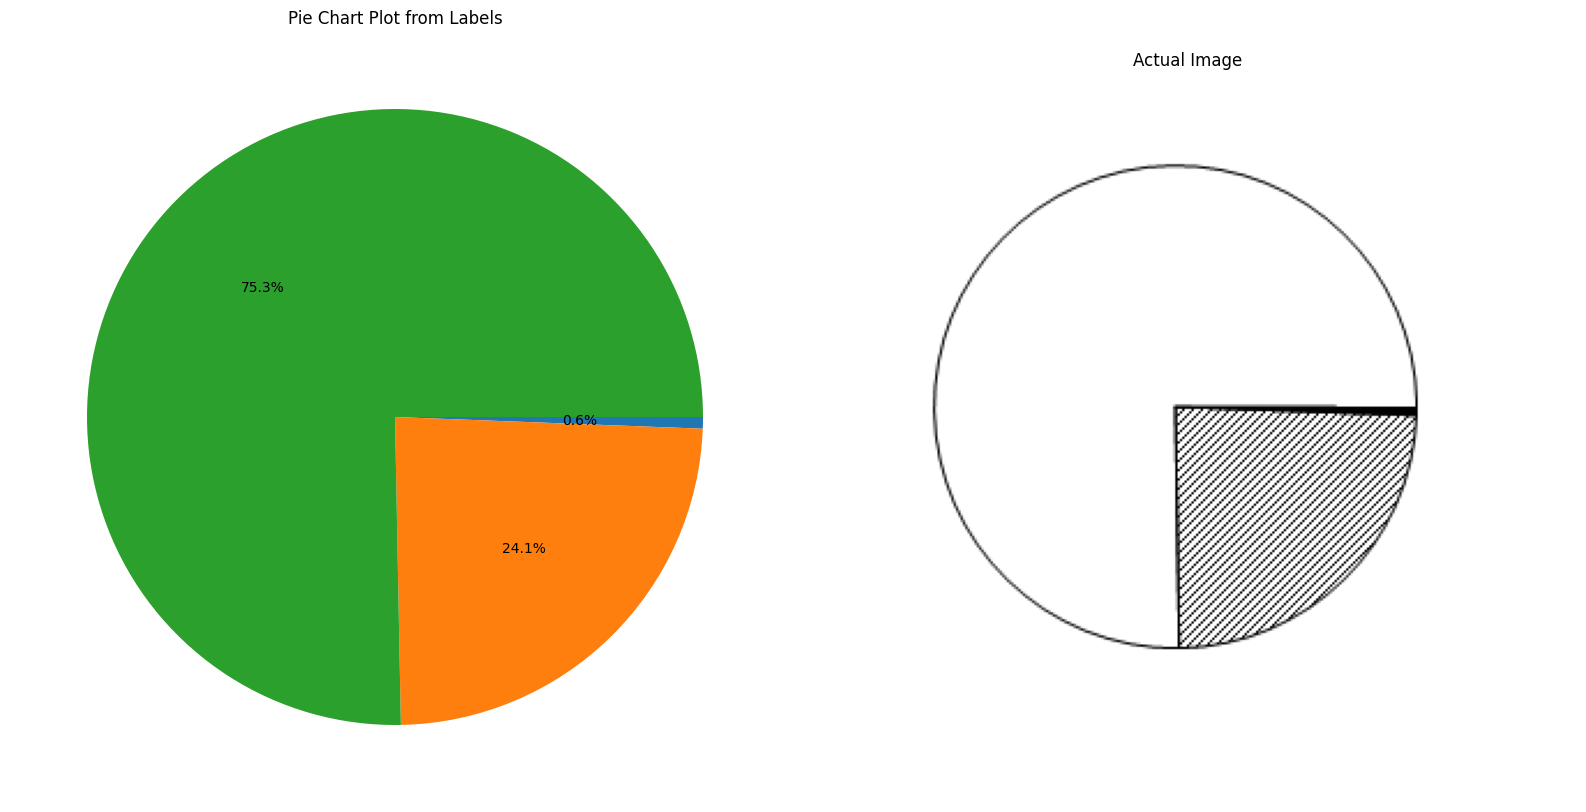

In [7]:
chart_idx = 0
chart_dict = train_df.loc[chart_idx]

print("Chart:", chart_dict["filename"])
print("Start Angle:", chart_dict["start_angles"][0])
print("Percentages:", chart_dict["percentages"])

# In matplotlib, 90° is the top and it adds segments counter-clockwise
# (use a negative sign to add them in clockwise order)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the pie chart from labels
ax[0].pie(
    chart_dict["percentages"],
    startangle=90 - chart_dict["start_angles"][0],
    counterclock=False,
    autopct='%1.1f%%',
)
ax[0].set_title("Pie Chart Plot from Labels")

# Load and display the actual image of the chart
image_path = f"./think-cell-datathon/images/images/{chart_dict['filename']}"
img = plt.imread(image_path)
ax[1].imshow(img)
ax[1].axis("off")
ax[1].set_title("Actual Image")
plt.tight_layout()
plt.show()

In [703]:
import numpy as np
import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns clockwise the angle in radians between vectors 'v1' and 'v2'::

    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    
    dot = np.dot(v1_u,v2_u)
    cross = np.cross(v1_u,v2_u)
    
    angle = np.arctan2(cross,dot)
    
    return np.mod((2 * np.pi - angle), (2 * np.pi))


def convert_coord(c, height):
    
    return c[0], height - c[1]


def find_top(centered_arcs):
    
    right_points = [c for c in centered_arcs if c[0] >= 0]
    
    if len(right_points) > 0:
        top = max(right_points, key=lambda c: (c[1], -c[0]))
        return top
    left_points = [c for c in centered_arcs if c[0] < 0]
    return min(left_points, key=lambda c: (c[1], -c[0]))


def compute_all_radius(centers, arc_points):
    radius = []
    
    for c_x, c_y in centers:
        for p_x, p_y in arc_points:
            r_ = np.sqrt((c_x - p_x)**2 + (c_y - p_y)**2)
            if r_ == 94.54099639838793:
                plt.scatter(p_x, height - p_y, c='r')
                plt.scatter(c_x, height - c_y, c='r')
            radius.append(r_)
            
    return radius

def center_arcs(arc_points, center):
    center_x, center_y = center

    centered_arcs = []
    for x, y in arc_points:
        centered_arcs.append((x - center_x, y - center_y))
    return centered_arcs

def get_angle_dict(ref, centered_arcs):
    angle_dict = {}
    for c in centered_arcs:
        angle = angle_between(ref, c)

        angle_dict[angle] = c
    return angle_dict


def get_count(all_r, threshold):
    max_count = 0
    for r_base in all_r:
        count = 0
        for r in all_r:
            if abs((r-r_base)/r_base) <= threshold:
                count += 1
        if count > max_count:
            max_count = count
            record_r = r_base
    return record_r, max_count


def binary_search(all_r, tar_count):
    lt = 0.05
    lr = 0.2
    record_r, count = get_count(all_r, (lt+lr)/2)
    while (lr-lt) > 1e-3:
        if count < tar_count:
            lt = (lr+lt)/2
        else:
            lr = (lr+lt)/2
        record_r, count = get_count(all_r, (lt + lr) / 2)
    return record_r, lt


def sector_area(start, end):
    
    start_x, start_y = start
    end_x, end_y = end

    r = np.sqrt((start_x)**2 + (start_y)**2)

    angle = angle_between(start, end)

    area = (angle / (2 * np.pi)) * np.pi * r**2

    return area


def cross(a):
    center_x, center_y = center
    left_x, left_y = a
    x1 = left_x - center_x
    y1 = left_y - center_y
    theta_y = math.degrees(math.acos((-y1 / math.sqrt(x1 * x1 + y1 * y1))))
    if x1 < 0:
        theta_y = 360 - theta_y
    return theta_y


def cal_dis(a, b):
    return np.sqrt(math.pow(a[0]-b[0], 2)+math.pow(a[1]-b[1], 2))

def multi_center(center_points, arc_points):
    rads = compute_all_radius(center_points, arc_points)
    r_star, t = binary_search(rads, len(arc_points))
    
    # lt = 0.05
    # lr = 0.2
    # max_count = -1
    # while lr - lt > 0.001:
    #     for r in rads:        
    #         count = len([r_ for r_ in rads if ((r_ - r) / r) < (lr + lt) / 2])
    #         if count > max_count:
    #             max_count = count
    #             r_star = r
    #             t = lt
    #     if max_count < len(arc_points):
    #         lt = (lr + lt) / 2
    #     else:
    #         lr = (lr + lt) / 2
    
    global center
    center = center_points[0]
    key_points = sorted(arc_points, key=cross, reverse=True)
    areas = []
    
    for i in range(len(key_points)):
        key_point = key_points[i]
        for j in range(len(center_points)):
            r_ = cal_dis(key_point, center_points[j])
            if abs((r_-r_star)/r_star) <= t:
                tar_center = center_points[j]
                break
        r_ = cal_dis(key_points[(i+1)%len(key_points)], tar_center)
        if abs((r_ - r_star) / r_star) <= t:
            arcs_ = [key_points[i], key_points[(i+1)%len(key_points)]]
            
            print(arcs_)
            
            xs = [key_points[i][0], key_points[(i+1)%len(key_points)][0]]
            ys = [height - key_points[i][1], height - key_points[(i+1)%len(key_points)][1]]
            
            plt.scatter(xs, ys, c='g')

            centered_arcs_ = center_arcs(arcs_, tar_center)
            area = sector_area(*centered_arcs_)
            areas.append(area)
            # groups.append([tuple(tar_center['bbox'][0:2]), tuple(key_points[i]['bbox'][0:2]), tuple(key_points[(i+1)%len(key_points)]['bbox'][0:2]), score])
#     dist = lambda x, y: np.sqrt((x)**2 + (y)**2)
    
#     print(r_star, t)
#     areas = []
#     for c in centers:
#         centered_arcs = center_arcs(arc_points, c)
#         for p in centered_arcs:
#             angle_dict = get_angle_dict(p, centered_arcs)
#             del angle_dict[0]
#             _, nearest = min(angle_dict.items(), key=lambda x: x[0])
#             if ((dist(*p) - r_star) / r_star) < t and ((dist(*nearest) - r_star) / r_star) < t:
#                 area = sector_area(p, nearest)
#                 areas.append(area)
    total_area = sum(areas)
    percentages = [100 * area / total_area for area in areas]
    return percentages

    
def arcs_to_sectors(centers, arc_points):
    if len(centers) == 1:
        
        centered_arcs = center_arcs(arc_points, centers[0])

        top_point = find_top(centered_arcs)

        angle_dict = get_angle_dict(top_point, centered_arcs)

        clock_wise_sorted_arcs = [angle_dict[angle] for angle in sorted(angle_dict.keys())]
        clock_wise_sorted_arcs.append(top_point)

        areas = []
        for i in range(len(clock_wise_sorted_arcs) - 1):

            area = sector_area(clock_wise_sorted_arcs[i], clock_wise_sorted_arcs[i + 1])
            areas.append(area)

        total_area = sum(areas)
        percentages = [100 * area / total_area for area in areas]

        return percentages
    else:
        return multi_center(centers, arc_points)
    

[1.6917929074406717, 37.12995310873855, 61.17825398382079]
[0.3421525326652919, 33.66528173954913, 65.99256572778557]
0.6080441336480269


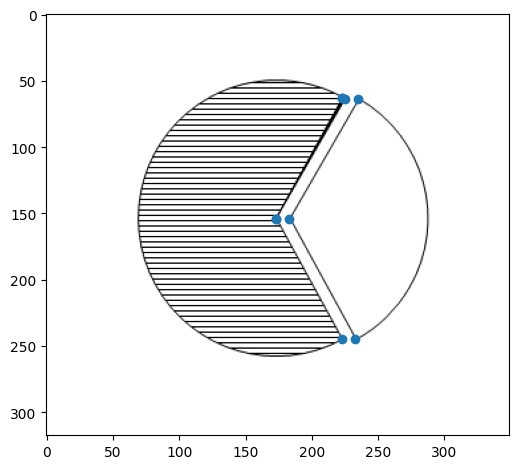

In [709]:
import random

# chart_idx = 5318
chart_idx = 5055
chart_dict = train_df.loc[chart_idx]

image_path = f"./think-cell-datathon/images/images/{chart_dict['filename']}"

img = plt.imread(image_path)

xs = []
ys = []
for d in chart_dict['boxes']:
    xs += [d[0], d[2], d[4]]
    ys += [d[1], d[3], d[5]]
    
plt.scatter(xs, ys)
plt.imshow(img)
plt.tight_layout()

height, width, _ = img.shape
boxes = list(chart_dict["boxes"])

random.shuffle(boxes)
centers = set()

arcs = set()

for x1,y1, _,_, x3,y3 in boxes:
    arcs.add(convert_coord((x1, y1), height))
    centers.add(convert_coord((x3, y3), height))
    
arcs = list(arcs)
centers = list(centers)
centers = [list(centers)[0]]

percentages = arcs_to_sectors(centers, arcs)

true_percentages = chart_dict['percentages']

s = {}
def score(i, j):
    if (i, j) in s:
        return s[(i, j)]
    if i == -1 or j == -1:
        return 0


    s_ = max(score(i - 1, j), score(i, j - 1), score(i - 1, j - 1) + 1 - np.abs((percentages[i] - true_percentages[j]) / true_percentages[j]))
    s[(i, j)] = s_
    return s_

sc = score(len(percentages) - 1, len(true_percentages) - 1) / len(true_percentages)  

print(percentages)
print(chart_dict['percentages'])
print(sc)
plt.show()


In [669]:
for x1,y1, _,_, x3,y3 in boxes:
    print(np.sqrt((x1 - x3)**2 + (y1 - y3)**2))

77.0
77.38862965578342
76.55716818169282
76.53757247260981


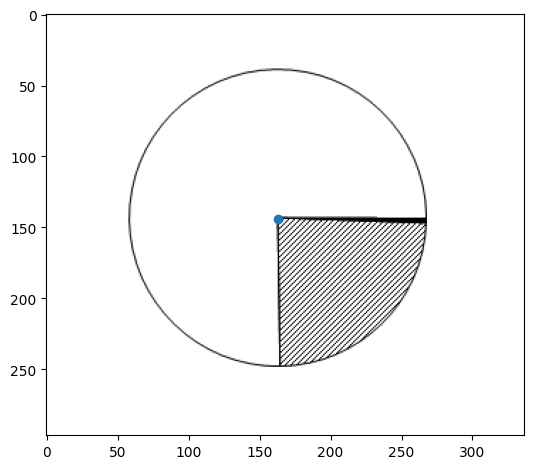

In [121]:
img.shape

(297, 337, 4)

In [143]:
57.29578 * 1.6354713004368842

93.70560382614562

In [181]:
3.1 % np.pi

3.1

In [624]:
from tqdm import tqdm

def test():
    error_idx = []
    diff = 0
    scores = []
    tot = 0
    for index in tqdm(range(len(train_df))):
    # for index in tqdm(range(62, 63)):

        chart_idx = index
        chart_dict = train_df.loc[chart_idx]

        image_path = f"./think-cell-datathon/images/images/{chart_dict['filename']}"

        img = plt.imread(image_path)

        height, width, _ = img.shape
        boxes = list(chart_dict["boxes"])

        random.shuffle(boxes)

        center = convert_coord(boxes[0][-2:], height)

        arcs = set()

        for x1,y1, _,_, _,_ in boxes:
            arcs.add(convert_coord((x1, y1), height))

        arcs = list(arcs)

        percentages = arcs_to_sectors(center, arcs)
        true_percentages = chart_dict['percentages']
        s = {}
        def score(i, j):
            if (i, j) in s:
                return s[(i, j)]
            if i == -1 or j == -1:
                return 0
            
            
            s_ = max(score(i - 1, j), score(i, j - 1), score(i - 1, j - 1) + 1 - np.abs((percentages[i] - true_percentages[j]) / true_percentages[j]))
            s[(i, j)] = s_
            return s_
            
        scores.append(score(len(percentages) - 1, len(true_percentages) - 1) / len(true_percentages))

        if len(percentages) == len(chart_dict['percentages']):
            for p1, p2 in zip(percentages, chart_dict['percentages']):
                diff += np.abs(p1 - p2)
                tot+=1
        else:
            error_idx.append(chart_idx)
    return diff, error_idx, tot, scores

In [625]:
diff, error, tot, scores = test()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 300.90it/s]


In [626]:
diff

9517.853980899152

In [627]:
diff / tot

0.1585621893995794

In [247]:
tot

60026

In [283]:
diff

40163.7173991958

In [251]:
bad

[4,
 9,
 14,
 14,
 14,
 14,
 15,
 15,
 16,
 16,
 22,
 29,
 29,
 32,
 32,
 44,
 44,
 45,
 48,
 48,
 63,
 63,
 69,
 69,
 69,
 69,
 69,
 71,
 71,
 72,
 72,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 86,
 90,
 90,
 97,
 112,
 112,
 113,
 118,
 127,
 127,
 131,
 131,
 131,
 137,
 137,
 149,
 155,
 155,
 155,
 155,
 155,
 155,
 155,
 155,
 155,
 155,
 157,
 157,
 157,
 157,
 157,
 157,
 157,
 157,
 157,
 157,
 157,
 162,
 162,
 163,
 163,
 164,
 171,
 171,
 175,
 182,
 186,
 188,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 226,
 226,
 254,
 254,
 254,
 254,
 260,
 263,
 265,
 265,
 267,
 267,
 281,
 281,
 282,
 282,
 282,
 285,
 285,
 297,
 297,
 297,
 297,
 298,
 298,
 299,
 299,
 310,
 313,
 321,
 321,
 321,
 321,
 321,
 334,
 334,
 335,
 354,
 366,
 366,
 380,
 380,
 380,
 380,
 380,
 380,
 380,
 380,
 385,
 385,
 385,
 388,
 388,
 388,
 396,
 396,
 396,
 396,
 398,
 412,
 415,
 440,
 440,
 446,
 446,
 446,
 446,
 446,
 446,
 446,
 446,
 446,
 446,

In [258]:
np.mean(bad)

5130.973730740086

In [628]:
np.mean(scores)

0.9874926109588076